<a href="https://colab.research.google.com/github/sedaoturak/cVAE_Mechanical_MNIST/blob/main/cVAE_mechanical_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd.variable import Variable
import matplotlib.pyplot as plt
import numpy as np
import random
import tqdm.notebook

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

# with open('/content/drive/MyDrive/toy_datasets/Mechanical_MNIST/mnist_img_train.txt', 'r') as f: 
#   g = np.loadtxt(f)
# with open('/content/drive/MyDrive/toy_datasets/Mechanical_MNIST/summary_psi_train_all.txt', 'r') as f:
#   e = np.loadtxt(f)

with open('/content/drive/MyDrive/toy_datasets/Mechanical_MNIST/Case1_input_patterns_64_x_64.txt', 'r') as f: 
  g = np.loadtxt(f)
with open('/content/drive/MyDrive/toy_datasets/Mechanical_MNIST/Case1_strain_energy.txt', 'r') as f:
  e = np.loadtxt(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


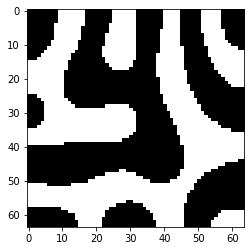

In [4]:
import matplotlib.pyplot as plt
import numpy as np

img = g.reshape(37523,64,64)
plt.imshow(img[9,:,:], interpolation='nearest', cmap='binary')
plt.show()

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
e_scaled = scaler.fit_transform(e[:,6].reshape(-1, 1))
e_scaled.shape, e_scaled.ravel().shape

images = g.reshape((37523,64,64))
energies = e_scaled.ravel()

images.shape, energies.shape

((37523, 64, 64), (37523,))

In [6]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
  def __init__(self, imgs, labels, transform):
    self.labels = labels
    self.imgs = imgs
    self.transform = transform

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, index):
    x = self.imgs[index]
    x = self.transform(x)
    y = self.labels[index]
    return x, y

b, w, h, = [*images.shape]
print(images.shape)
images_wb = np.repeat(images[..., np.newaxis], 1, -1)
print(images_wb.shape)
images_wb = images_wb.reshape(b, 1, w, h)
print(images_wb.shape)

(37523, 64, 64)
(37523, 64, 64, 1)
(37523, 1, 64, 64)


In [7]:
transform = transforms.Compose([
      # transforms.Resize((32, 32)),
      #transforms.RandomRotation(degrees= (0, 180)),
      # transforms.RandomRotation(180),
      # transforms.RandomRotation(90),
     
      # transforms.RandomHorizontalFlip(0.5),
      # transforms.RandomVerticalFlip(0.5),
      #transforms.ColorJitter(brightness=(0.5,1.5),contrast=(1),saturation=(0.5,1.5),hue=(-0.1,0.1)),
      # transforms.ToTensor(),
      #transforms.Normalize([0.2732, 0.2728, 0.2713], [0.1937, 0.1943, 0.1933]),
        ])

# Datasets
normalized_images = images_wb # use "/255" for rgb images, but for white-black images
data = torch.tensor(normalized_images, dtype=torch.float32)
target = torch.tensor(energies, dtype=torch.float32).reshape(-1,1)   #target

if __name__ == "__main__":
  dataset = CustomDataset(data, target, transform)

In [8]:
train_set_size = int(len(dataset)*0.8)
val_set_size = len(dataset) - train_set_size

trainset, valset  = random_split(dataset, [train_set_size, val_set_size])
batch_size = 64
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers= 2)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers= 2)

In [ ]:
trainset.dataset.imgs.shape

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
kernel_size = 4 # (4, 4) kernel
init_channels = 32 # initial number of filters
image_channels = 1 # MNIST images are grayscale
latent_dim = 2 # latent dimension for sampling

# define a Conv VAE
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*4, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*8, out_channels=64, kernel_size=kernel_size, 
            stride=2, padding=0
        )
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=1, padding=0
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.dec5 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x):
        # encoding
        # print(f'x.size {(x.size())}')
        x = F.relu(self.enc1(x))
        # print(f'x.size {(x.size())}')
        x = F.relu(self.enc2(x))
        # print(f'x.size {(x.size())}')
        x = F.relu(self.enc3(x))
        # print(f'x.size {(x.size())}')
        x = F.relu(self.enc4(x))
        # print(f'x.size {(x.size())}')
        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        # print(f'x.size after adaptive pooling {(x.size())}')
        hidden = self.fc1(x)
        # print(f'x.size after hidden layer in encoder {(x.size())}')
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        # print(f'z.size {(z.size())}')
        z = self.fc2(z)
        # print(f'z size after fc2: {z.size()}')
        z = z.view(-1, 64, 1, 1)
        # print(f'z size after view(-1, 64, 1, 1): {z.size()}')
 
        # decoding
        x = F.relu(self.dec1(z))
        # print(f'x size after 1 transcov: {x.size()}')
        x = F.relu(self.dec2(x))
        # print(f'x size after 2 transcov: {x.size()}')
        x = F.relu(self.dec3(x))
        # print(f'x size after 3 transcov: {x.size()}')
        x = F.relu(self.dec4(x))
        # print(f'x size after 3 transcov: {x.size()}')
        reconstruction = torch.sigmoid(self.dec5(x))
        # print(f'x size after 4 transcov: {reconstruction.size()}')
        return reconstruction, mu, log_var

In [44]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import matplotlib
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# initialize the model
model = ConvVAE().to(device)
# set the learning parameters
lr = 0.001
epochs = 100
batch_size = 64
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss(reduction='mean')
# a list to save all the reconstructed images in PyTorch grid format
grid_images = []

In [45]:
from tqdm import tqdm
import torch 
def final_loss(mse_loss, beta, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = mse_loss 
    KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)
    return BCE + beta*KLD

def train(dataloader, dataset, beta):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, (data,target) in tqdm(enumerate(dataloader)):
        counter += 1
        # data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        # print(f'in training loop, input size: {data.shape}, rec size: {reconstruction.shape}')
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, beta, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss / counter 
    return train_loss

def validate(dataloader, dataset, beta):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, (data,target) in tqdm(enumerate(dataloader)):
            counter += 1
            # data= data[0]
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, beta, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(dataset)/dataloader.batch_size) - 1:
                recon_images = reconstruction
    val_loss = running_loss / counter
    return val_loss, recon_images

In [46]:
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    if epoch<30:
      beta=0
    else:
      beta=1e-3
    train_epoch_loss = train(trainloader, trainset, beta)
    valid_epoch_loss, recon_images = validate(valloader, valset, beta)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

Epoch 1 of 100


470it [00:12, 37.14it/s]
118it [00:01, 91.75it/s]

Train Loss: 0.2295
Val Loss: 0.2192
Epoch 2 of 100



470it [00:12, 36.96it/s]
118it [00:01, 89.38it/s]

Train Loss: 0.2140
Val Loss: 0.2113
Epoch 3 of 100



470it [00:12, 36.48it/s]
118it [00:01, 91.12it/s]

Train Loss: 0.2085
Val Loss: 0.2096
Epoch 4 of 100



470it [00:12, 37.11it/s]
118it [00:01, 90.51it/s]

Train Loss: 0.2048
Val Loss: 0.2040
Epoch 5 of 100



470it [00:13, 34.89it/s]
118it [00:01, 91.32it/s] 

Train Loss: 0.2012
Val Loss: 0.2023
Epoch 6 of 100



470it [00:12, 37.35it/s]
118it [00:01, 93.14it/s] 

Train Loss: 0.1990
Val Loss: 0.2004
Epoch 7 of 100



470it [00:12, 37.12it/s]
118it [00:01, 91.20it/s]

Train Loss: 0.1968
Val Loss: 0.2023
Epoch 8 of 100



470it [00:13, 34.89it/s]
118it [00:01, 73.94it/s]

Train Loss: 0.1959
Val Loss: 0.1994
Epoch 9 of 100



470it [00:12, 37.17it/s]
118it [00:01, 91.78it/s] 

Train Loss: 0.1938
Val Loss: 0.1987
Epoch 10 of 100



470it [00:12, 36.94it/s]
118it [00:01, 91.05it/s]

Train Loss: 0.1922
Val Loss: 0.1939
Epoch 11 of 100



470it [00:12, 36.90it/s]
118it [00:01, 90.71it/s]

Train Loss: 0.1909
Val Loss: 0.1930
Epoch 12 of 100



470it [00:12, 37.11it/s]
118it [00:01, 90.55it/s]

Train Loss: 0.1894
Val Loss: 0.1945
Epoch 13 of 100



470it [00:12, 37.11it/s]
118it [00:01, 91.01it/s] 

Train Loss: 0.1881
Val Loss: 0.1926
Epoch 14 of 100



470it [00:12, 37.21it/s]
118it [00:01, 90.66it/s] 

Train Loss: 0.1869
Val Loss: 0.1975
Epoch 15 of 100



470it [00:12, 37.18it/s]
118it [00:01, 91.34it/s]

Train Loss: 0.1871
Val Loss: 0.1908
Epoch 16 of 100



470it [00:12, 36.97it/s]
118it [00:01, 90.40it/s]

Train Loss: 0.1847
Val Loss: 0.1903
Epoch 17 of 100



470it [00:12, 36.84it/s]
118it [00:01, 91.65it/s] 

Train Loss: 0.1843
Val Loss: 0.1896
Epoch 18 of 100



470it [00:12, 37.15it/s]
118it [00:01, 92.17it/s]

Train Loss: 0.1831
Val Loss: 0.1881
Epoch 19 of 100



470it [00:12, 37.07it/s]
118it [00:01, 90.61it/s]

Train Loss: 0.1819
Val Loss: 0.1877
Epoch 20 of 100



470it [00:12, 37.18it/s]
118it [00:01, 90.93it/s]

Train Loss: 0.1810
Val Loss: 0.1863
Epoch 21 of 100



470it [00:12, 36.87it/s]
118it [00:01, 91.12it/s]

Train Loss: 0.1803
Val Loss: 0.1992
Epoch 22 of 100



470it [00:13, 34.35it/s]
118it [00:01, 90.95it/s]

Train Loss: 0.1826
Val Loss: 0.1864
Epoch 23 of 100



470it [00:12, 36.94it/s]
118it [00:01, 89.80it/s]

Train Loss: 0.1788
Val Loss: 0.1871
Epoch 24 of 100



470it [00:12, 36.87it/s]
118it [00:01, 90.44it/s]

Train Loss: 0.1788
Val Loss: 0.1859
Epoch 25 of 100



470it [00:12, 37.21it/s]
118it [00:01, 91.03it/s]

Train Loss: 0.1773
Val Loss: 0.1868
Epoch 26 of 100



470it [00:12, 36.95it/s]
118it [00:01, 90.00it/s]

Train Loss: 0.1761
Val Loss: 0.1884
Epoch 27 of 100



470it [00:12, 37.11it/s]
118it [00:01, 92.71it/s]

Train Loss: 0.1769
Val Loss: 0.1877
Epoch 28 of 100



470it [00:12, 36.89it/s]
118it [00:01, 91.50it/s] 

Train Loss: 0.1750
Val Loss: 0.1893
Epoch 29 of 100



470it [00:12, 37.00it/s]
118it [00:01, 90.37it/s]

Train Loss: 0.1753
Val Loss: 0.1854
Epoch 30 of 100



470it [00:12, 37.05it/s]
118it [00:01, 91.09it/s]

Train Loss: 0.1742
Val Loss: 0.1851
Epoch 31 of 100



470it [00:12, 37.07it/s]
118it [00:01, 92.23it/s]

Train Loss: 0.1838
Val Loss: 0.1970
Epoch 32 of 100



470it [00:12, 37.41it/s]
118it [00:01, 93.27it/s] 


Train Loss: 0.1834
Val Loss: 0.1925
Epoch 33 of 100


470it [00:12, 37.23it/s]
118it [00:01, 91.17it/s]

Train Loss: 0.1820
Val Loss: 0.1996
Epoch 34 of 100



470it [00:12, 37.00it/s]
118it [00:01, 85.71it/s]

Train Loss: 0.1839
Val Loss: 0.1933
Epoch 35 of 100



470it [00:13, 35.05it/s]
118it [00:01, 91.50it/s] 

Train Loss: 0.1811
Val Loss: 0.1937
Epoch 36 of 100



470it [00:12, 37.29it/s]
118it [00:01, 89.14it/s]

Train Loss: 0.1801
Val Loss: 0.1935
Epoch 37 of 100



470it [00:12, 37.11it/s]
118it [00:01, 90.69it/s]

Train Loss: 0.1803
Val Loss: 0.1944
Epoch 38 of 100



470it [00:12, 36.98it/s]
118it [00:01, 90.32it/s]

Train Loss: 0.1797
Val Loss: 0.1912
Epoch 39 of 100



470it [00:12, 37.04it/s]
118it [00:01, 91.00it/s]

Train Loss: 0.1786
Val Loss: 0.1921
Epoch 40 of 100



470it [00:12, 37.36it/s]
118it [00:01, 90.63it/s]

Train Loss: 0.1779
Val Loss: 0.1936
Epoch 41 of 100



470it [00:12, 37.23it/s]
118it [00:01, 92.38it/s] 

Train Loss: 0.1783
Val Loss: 0.1917
Epoch 42 of 100



470it [00:12, 37.26it/s]
118it [00:01, 89.08it/s]

Train Loss: 0.1774
Val Loss: 0.1950
Epoch 43 of 100



470it [00:12, 37.20it/s]
118it [00:01, 90.16it/s]

Train Loss: 0.1775
Val Loss: 0.1905
Epoch 44 of 100



470it [00:12, 37.27it/s]
118it [00:01, 91.13it/s] 

Train Loss: 0.1774
Val Loss: 0.1910
Epoch 45 of 100



470it [00:12, 37.24it/s]
118it [00:01, 89.84it/s]

Train Loss: 0.1761
Val Loss: 0.1919
Epoch 46 of 100



470it [00:13, 34.96it/s]
118it [00:01, 93.31it/s] 

Train Loss: 0.1761
Val Loss: 0.1933
Epoch 47 of 100



470it [00:12, 37.42it/s]
118it [00:01, 90.29it/s]

Train Loss: 0.1750
Val Loss: 0.1905
Epoch 48 of 100



470it [00:12, 37.04it/s]
118it [00:01, 90.73it/s]

Train Loss: 0.1747
Val Loss: 0.1920
Epoch 49 of 100



470it [00:12, 37.08it/s]
118it [00:01, 90.41it/s]

Train Loss: 0.1743
Val Loss: 0.1940
Epoch 50 of 100



470it [00:12, 37.14it/s]
118it [00:01, 92.57it/s] 


Train Loss: 0.1752
Val Loss: 0.1907
Epoch 51 of 100


470it [00:12, 37.26it/s]
118it [00:01, 89.89it/s]

Train Loss: 0.1734
Val Loss: 0.1951
Epoch 52 of 100



470it [00:12, 37.49it/s]
118it [00:01, 91.67it/s] 

Train Loss: 0.1744
Val Loss: 0.1913
Epoch 53 of 100



470it [00:12, 37.20it/s]
118it [00:01, 92.03it/s]


Train Loss: 0.1729
Val Loss: 0.1921
Epoch 54 of 100


470it [00:12, 37.18it/s]
118it [00:01, 91.05it/s]

Train Loss: 0.1724
Val Loss: 0.1897
Epoch 55 of 100



470it [00:12, 37.30it/s]
118it [00:01, 90.48it/s]

Train Loss: 0.1720
Val Loss: 0.1919
Epoch 56 of 100



470it [00:12, 37.44it/s]
118it [00:01, 91.70it/s] 

Train Loss: 0.1719
Val Loss: 0.1910
Epoch 57 of 100



470it [00:12, 37.30it/s]
118it [00:01, 91.76it/s] 

Train Loss: 0.1715
Val Loss: 0.1903
Epoch 58 of 100



470it [00:12, 36.64it/s]
118it [00:01, 65.65it/s]

Train Loss: 0.1711
Val Loss: 0.1907
Epoch 59 of 100



470it [00:13, 35.46it/s]
118it [00:01, 89.79it/s]

Train Loss: 0.1704
Val Loss: 0.1902
Epoch 60 of 100



470it [00:12, 36.68it/s]
118it [00:01, 89.56it/s]

Train Loss: 0.1703
Val Loss: 0.1906
Epoch 61 of 100



470it [00:12, 36.69it/s]
118it [00:01, 88.69it/s]

Train Loss: 0.1693
Val Loss: 0.1920
Epoch 62 of 100



470it [00:12, 36.96it/s]
118it [00:01, 91.23it/s]

Train Loss: 0.1699
Val Loss: 0.1915
Epoch 63 of 100



470it [00:12, 37.47it/s]
118it [00:01, 90.69it/s]

Train Loss: 0.1685
Val Loss: 0.1912
Epoch 64 of 100



470it [00:12, 36.91it/s]
118it [00:01, 91.02it/s]

Train Loss: 0.1685
Val Loss: 0.1936
Epoch 65 of 100



470it [00:12, 36.99it/s]
118it [00:01, 90.80it/s]

Train Loss: 0.1689
Val Loss: 0.1897
Epoch 66 of 100



470it [00:12, 37.12it/s]
118it [00:01, 92.76it/s] 


Train Loss: 0.1682
Val Loss: 0.1942
Epoch 67 of 100


470it [00:12, 37.10it/s]
118it [00:01, 91.52it/s]

Train Loss: 0.1676
Val Loss: 0.1896
Epoch 68 of 100



470it [00:12, 37.08it/s]
118it [00:01, 91.63it/s] 

Train Loss: 0.1668
Val Loss: 0.1967
Epoch 69 of 100



470it [00:12, 37.16it/s]
118it [00:01, 91.09it/s]

Train Loss: 0.1674
Val Loss: 0.1911
Epoch 70 of 100



470it [00:12, 36.99it/s]
118it [00:01, 90.83it/s]

Train Loss: 0.1663
Val Loss: 0.1906
Epoch 71 of 100



470it [00:12, 37.04it/s]
118it [00:01, 79.74it/s]

Train Loss: 0.1665
Val Loss: 0.1908
Epoch 72 of 100



470it [00:13, 34.75it/s]
118it [00:01, 89.66it/s]

Train Loss: 0.1662
Val Loss: 0.1916
Epoch 73 of 100



470it [00:12, 36.75it/s]
118it [00:01, 89.69it/s]

Train Loss: 0.1657
Val Loss: 0.1917
Epoch 74 of 100



470it [00:12, 36.95it/s]
118it [00:01, 90.79it/s]

Train Loss: 0.1659
Val Loss: 0.1918
Epoch 75 of 100



470it [00:12, 36.49it/s]
118it [00:01, 88.94it/s]

Train Loss: 0.1648
Val Loss: 0.1907
Epoch 76 of 100



470it [00:12, 36.50it/s]
118it [00:01, 89.80it/s]

Train Loss: 0.1644
Val Loss: 0.1916
Epoch 77 of 100



470it [00:12, 36.59it/s]
118it [00:01, 90.42it/s]

Train Loss: 0.1644
Val Loss: 0.1923
Epoch 78 of 100



470it [00:12, 36.42it/s]
118it [00:01, 89.53it/s]

Train Loss: 0.1645
Val Loss: 0.1906
Epoch 79 of 100



470it [00:12, 36.69it/s]
118it [00:01, 90.97it/s]

Train Loss: 0.1634
Val Loss: 0.1912
Epoch 80 of 100



470it [00:12, 36.71it/s]
118it [00:01, 88.92it/s]

Train Loss: 0.1637
Val Loss: 0.1996
Epoch 81 of 100



470it [00:12, 36.43it/s]
118it [00:01, 88.73it/s]

Train Loss: 0.1649
Val Loss: 0.1941
Epoch 82 of 100



470it [00:12, 36.69it/s]
118it [00:01, 91.17it/s]

Train Loss: 0.1635
Val Loss: 0.1903
Epoch 83 of 100



470it [00:12, 36.73it/s]
118it [00:01, 89.85it/s]

Train Loss: 0.1622
Val Loss: 0.1919
Epoch 84 of 100



470it [00:12, 36.62it/s]
118it [00:01, 72.26it/s]

Train Loss: 0.1625
Val Loss: 0.1905
Epoch 85 of 100



470it [00:13, 34.43it/s]
118it [00:01, 89.35it/s]

Train Loss: 0.1618
Val Loss: 0.1894
Epoch 86 of 100



470it [00:12, 36.56it/s]
118it [00:01, 90.69it/s]

Train Loss: 0.1617
Val Loss: 0.1917
Epoch 87 of 100



470it [00:12, 36.52it/s]
118it [00:01, 89.85it/s]

Train Loss: 0.1624
Val Loss: 0.1911
Epoch 88 of 100



470it [00:12, 36.53it/s]
118it [00:01, 90.62it/s]

Train Loss: 0.1611
Val Loss: 0.1917
Epoch 89 of 100



470it [00:12, 36.52it/s]
118it [00:01, 89.50it/s]

Train Loss: 0.1609
Val Loss: 0.1904
Epoch 90 of 100



470it [00:12, 36.68it/s]
118it [00:01, 89.68it/s]

Train Loss: 0.1600
Val Loss: 0.1906
Epoch 91 of 100



470it [00:12, 36.55it/s]
118it [00:01, 89.03it/s]

Train Loss: 0.1610
Val Loss: 0.1912
Epoch 92 of 100



470it [00:12, 36.73it/s]
118it [00:01, 90.01it/s]

Train Loss: 0.1597
Val Loss: 0.1908
Epoch 93 of 100



470it [00:12, 36.98it/s]
118it [00:01, 90.78it/s]

Train Loss: 0.1606
Val Loss: 0.1903
Epoch 94 of 100



470it [00:12, 36.84it/s]
118it [00:01, 90.73it/s]

Train Loss: 0.1596
Val Loss: 0.1913
Epoch 95 of 100



470it [00:12, 37.07it/s]
118it [00:01, 91.18it/s] 

Train Loss: 0.1592
Val Loss: 0.1903
Epoch 96 of 100



470it [00:12, 37.16it/s]
118it [00:01, 90.56it/s]

Train Loss: 0.1590
Val Loss: 0.1953
Epoch 97 of 100



470it [00:13, 34.35it/s]
118it [00:01, 89.96it/s]

Train Loss: 0.1599
Val Loss: 0.1922
Epoch 98 of 100



470it [00:12, 36.88it/s]
118it [00:01, 90.17it/s]

Train Loss: 0.1589
Val Loss: 0.1921
Epoch 99 of 100



470it [00:12, 37.04it/s]
118it [00:01, 90.00it/s]

Train Loss: 0.1582
Val Loss: 0.1913
Epoch 100 of 100



470it [00:12, 37.04it/s]
118it [00:01, 91.69it/s]


Train Loss: 0.1581
Val Loss: 0.1920


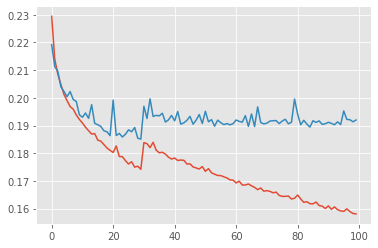

In [47]:
fig, ax = plt.subplots()
ax.plot(train_loss)
ax.plot(valid_loss)

In [36]:
PATH = '/content/drive/MyDrive/mech_MNIST'
torch.save(model, PATH)

In [38]:
# save to disk
import os
model_scripted = torch.jit.script(model.cpu())
model_scripted.save(os.path.join('/content/drive/MyDrive/', f'mech_MNIST-scripted.pt'))

In [39]:
torch.save(model.state_dict(), PATH)